### Data process

In [1]:
import torch as t
import numpy as np
from PIL import Image
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import lightgbm as lgb
import matplotlib.pyplot as plot
from data.ml_dataset import BODataSet
import time
import os
import torch.nn as nn
import random

C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
# get dataset
dataset = BODataSet(root="./data/trimer/pg")
class_labels = ('normal', 'hypopnea', 'apnea')
X, Y = dataset.get_data()
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=33)
len(train_X), len(test_X)
train_X[0]

何文东
杨梓恒
林颖晞
舒辰熙
陈知浅
高子羲


array([  9.80000000e+01,   9.50000000e+01,   9.62500000e+01,
         6.87500000e-01,   8.29156198e-01,   9.60000000e+01,
         8.61460985e-03,   1.01818182e+00,   9.87012987e-01,
         3.37416142e-02,  -6.95446796e-01,  -5.00000000e-02,
         4.83050847e-02,  -1.00000000e+00,  -4.23613061e+00,
         1.64937753e+01,   1.00000000e+00,   0.00000000e+00,
         3.00000000e+00,   9.62500000e+01,   6.99152542e-01,
         9.80000000e+01,   9.50000000e+01,   3.37416142e-02,
        -6.95446796e-01])

In [36]:
# data enhance
def upsampling(frags, labels):
        class_count = [0, 0, 0]
        for label in labels:
            class_count[label] += 1
        class_max = max(class_count)
        print(class_count, class_max)

        for i in range(len(frags)):
            duplicate = class_max / class_count[labels[i]] - 1
            duplicate_integer = int(duplicate)
            duplicate_decimal = duplicate - int(duplicate)
            # print(self.frags[i][1], duplicate_integer, duplicate_decimal)

            frags.extend([frags[i] for x in range(duplicate_integer)])
            labels.extend([labels[i] for x in range(duplicate_integer)])
            if random.uniform(0, 1) < duplicate_decimal:
                frags.append(frags[i])
                labels.append(labels[i])

        class_count = [0, 0, 0]
        for label in labels:
            class_count[label] += 1
        print(class_count)
        return frags

upsampling(train_X, train_Y)
#upsampling(test_X, test_Y)
len(train_X)

[2360, 666, 1003] 2360
[2360, 2394, 2364]


7118

### 数据预处理
归一化，二值化等操作

In [2]:
from sklearn import preprocessing

min_max_scale = preprocessing.MinMaxScaler()
X_scale = min_max_scale.fit_transform(X)
test_X_scale = min_max_scale.fit_transform(test_X)

X_normalize = preprocessing.normalize(X)
test_X_normalize = preprocessing.normalize(test_X)
train_X[0].shape

NameError: name 'X' is not defined

In [24]:
# test code
def test(clf, X, Y):
    class_labels = ('normal', 'hypopnea', 'apnea')
    class_total = [0, 0, 0]
    class_correct = [0, 0, 0]
    pre_Y = clf.predict(X)
    prediction = (pre_Y == Y)
    for index in range(len(Y)):
        label = Y[index]
        class_total[label] += 1
        class_correct[label] += prediction[index]
    
    accs = []
    accs.append("Total %d events accuracy: %.1f %%"%(sum(class_total), sum(class_correct) / sum(class_total) *100))
    accs.append("Total %d abnormal accuracy: %.1f %%" %(class_total[1]+class_total[2], (class_correct[1]+class_correct[2])/(class_total[1]+class_total[2]) *100))
    accs.extend(["%s %d events accuracy: %.1f %%" %(class_labels[i], class_total[i], class_correct[i] / class_total[i] *100 if class_total[i] != 0 else -1) for i in range(3)])
    print('\n'.join(accs), "\n")
    
    
    print("Precision_score: %.1f " % (metrics.precision_score(Y, pre_Y, average='weighted')*100))
    print("recall_score: %.1f " % (metrics.recall_score(Y, pre_Y, average='weighted')*100))
    print("f1_score: %.1f " % (metrics.f1_score(Y, pre_Y, average='weighted')*100))
    return pre_Y

# calculate accuracy
def calc_accuracy(Y, pre_Y):
    class_labels = ('normal', 'hypopnea', 'apnea')
    class_total = [0, 0, 0]
    class_correct = [0, 0, 0]
    prediction = (pre_Y == Y)
    #print(prediction)
    for index in range(len(Y)):
        label = Y[index]
        class_total[label] += 1
        class_correct[label] += prediction[index]
    
    accs = []
    accs.append("Total %d events accuracy: %.1f %%"%(sum(class_total), sum(class_correct) / sum(class_total) *100))
    accs.append("Total %d abnormal accuracy: %.1f %%" %(class_total[1]+class_total[2], (class_correct[1]+class_correct[2])/(class_total[1]+class_total[2]) *100))
    accs.extend(["%s %d events accuracy: %.1f %%" %(class_labels[i], class_total[i], class_correct[i] / class_total[i] *100 if class_total[i] != 0 else -1) for i in range(3)])
    
    print('\n'.join(accs), "\n")
    
    print("Precision_score: %.1f " % (metrics.precision_score(Y, pre_Y, average='weighted')*100))
    print("recall_score: %.1f " % (metrics.recall_score(Y, pre_Y, average='weighted')*100))
    print("f1_score: %.1f " % (metrics.f1_score(Y, pre_Y, average='weighted')*100))
    

### SVM

In [3]:

svm_clf = svm.SVC()
# param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma':[0.0001, 0.001, 0.01, 0.1, 0.3],}

# svm_clf_cv = GridSearchCV(svm.SVC(decision_function_shape='ovo', kernel='rbf'),param_grid, n_jobs=8, verbose=2, scoring='f1_macro')
# svm_clf_cv.fit(X,Y)

# svm_clf = svm.SVC(decision_function_shape='ovo', C=svm_clf_cv.best_params_['C'], gamma=svm_clf_cv.best_params_['gamma'])
# svm_clf.fit(train_X, train_Y)

test(svm_clf, test_X, test_Y)


print(svm_clf_cv.best_params_['C'], svm_clf_cv.best_params_['gamma'])

NameError: name 'test' is not defined

In [9]:
import pylab as pl

In [10]:
svm_clf.fit(train_X,train_Y)
test(svm_clf, test_X, test_Y)
len(svm_clf.support_vectors_)

Total 1728 events accuracy: 71.7 %
Total 728 abnormal accuracy: 56.7 %
normal 1000 events accuracy: 82.6 %
hypopnea 319 events accuracy: 47.0 %
apnea 409 events accuracy: 64.3 % 

Precision_score: 72.6 
recall_score: 71.7 
f1_score: 72.1 


4817

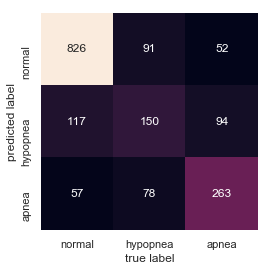

In [11]:
# confusion matrix 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix

pre = svm_clf.predict(test_X)
mat = confusion_matrix(test_Y, pre)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
# plt.figure()
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.rcParams['figure.dpi'] = 100 #分辨率
plt.savefig("./cm_svm")
# plt.rcParams.update({'font.size': 40})
# plt.show()

### RandomForest

In [13]:
#print(clf.best_estimator_.get_params())
best_rf_model = RandomForestClassifier(max_depth=20, max_features=0.7, criterion='gini', max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=2, n_estimators=10)
best_rf_model.fit(train_X, train_Y)
test(best_rf_model, test_X, test_Y)
best_rf_model.feature_importances_

Total 1728 events accuracy: 67.0 %
Total 728 abnormal accuracy: 53.6 %
normal 1000 events accuracy: 76.8 %
hypopnea 319 events accuracy: 41.7 %
apnea 409 events accuracy: 62.8 % 

Precision_score: 69.0 
recall_score: 67.0 
f1_score: 67.9 


array([ 0.01381475,  0.03951031,  0.04493407,  0.1018717 ,  0.07893957,
        0.00906742,  0.14867059,  0.04235379,  0.0665661 ,  0.04909919,
        0.05170565,  0.01220902,  0.02366754,  0.00032732,  0.02486151,
        0.01730712,  0.00229257,  0.05506281,  0.00054336,  0.045435  ,
        0.05039593,  0.01265836,  0.02258074,  0.04070333,  0.04542225])

### Xgboost

In [14]:
import xgboost as xgb
from xgboost import XGBClassifier

params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 3,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.1,                  # 如同学习率
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
}
plst = params.items()

dtrain = xgb.DMatrix(train_X, train_Y)
d_test_X = xgb.DMatrix(test_X)
model = xgb.train(plst, dtrain, 100)

test(model, d_test_X, test_Y)

Total 1728 events accuracy: 69.5 %
Total 728 abnormal accuracy: 57.8 %
normal 1000 events accuracy: 78.0 %
hypopnea 319 events accuracy: 47.3 %
apnea 409 events accuracy: 66.0 % 

Precision_score: 71.3 
recall_score: 69.5 
f1_score: 70.3 


In [15]:
xgb_clf = XGBClassifier(learning_rate=0.1)
xgb_clf.fit(np.array(train_X), train_Y)

test(xgb_clf, np.array(test_X), test_Y)

Total 1728 events accuracy: 72.3 %
Total 728 abnormal accuracy: 58.4 %
normal 1000 events accuracy: 82.5 %
hypopnea 319 events accuracy: 53.0 %
apnea 409 events accuracy: 62.6 % 

Precision_score: 73.8 
recall_score: 72.3 
f1_score: 73.0 


### LGB

In [16]:
# light gbn models
train_data = lgb.Dataset(np.array(train_X), train_Y)
test_data = lgb.Dataset(np.array(test_X), label=test_Y)

params = {
    'task': 'train',
    'n_estimators': 30,
    'objective': 'multiclass',
    'max_depth': 50,
    'num_class': 3,
#     'metric': 'auc',
    'learning_rate': 0.1,
#     'verbose': 0
}

bst = lgb.train(params, train_data, valid_sets=test_data)

y_pred = bst.predict(test_X)
y_pred = np.array([list(e).index(max(e)) for e in y_pred])

calc_accuracy(test_Y, y_pred)
# bst.save_model('model.txt')
# json_model = bst.dump_model()
# bst = lgb.Booster(model_file='model.txt')


C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.04657
[2]	valid_0's multi_logloss: 1.00238
[3]	valid_0's multi_logloss: 0.965334
[4]	valid_0's multi_logloss: 0.932918
[5]	valid_0's multi_logloss: 0.905295
[6]	valid_0's multi_logloss: 0.880772
[7]	valid_0's multi_logloss: 0.859548
[8]	valid_0's multi_logloss: 0.841094
[9]	valid_0's multi_logloss: 0.824506
[10]	valid_0's multi_logloss: 0.810644
[11]	valid_0's multi_logloss: 0.797769
[12]	valid_0's multi_logloss: 0.786185
[13]	valid_0's multi_logloss: 0.775991
[14]	valid_0's multi_logloss: 0.767809
[15]	valid_0's multi_logloss: 0.760428
[16]	valid_0's multi_logloss: 0.754636
[17]	valid_0's multi_logloss: 0.748558
[18]	valid_0's multi_logloss: 0.744487
[19]	valid_0's multi_logloss: 0.739521
[20]	valid_0's multi_logloss: 0.735946
[21]	valid_0's multi_logloss: 0.732822
[22]	valid_0's multi_logloss: 0.72968
[23]	valid_0's multi_logloss: 0.726768
[24]	valid_0's multi_logloss: 0.72367
[25]	valid_0's multi_logloss: 0.721045
[26]	valid_0's multi_logloss: 0.719212

### KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, p=5, metric='minkowski')
knn.fit(train_X,train_Y)

test(knn, test_X, test_Y)

Total 1728 events accuracy: 62.0 %
Total 728 abnormal accuracy: 43.7 %
normal 1000 events accuracy: 75.3 %
hypopnea 319 events accuracy: 32.6 %
apnea 409 events accuracy: 52.3 % 

Precision_score: 62.8 
recall_score: 62.0 
f1_score: 62.4 


### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=10)
decision_tree.fit(train_X, train_Y)

test(decision_tree, test_X, test_Y)

Total 1728 events accuracy: 68.3 %
Total 728 abnormal accuracy: 52.2 %
normal 1000 events accuracy: 80.1 %
hypopnea 319 events accuracy: 52.0 %
apnea 409 events accuracy: 52.3 % 

Precision_score: 70.1 
recall_score: 68.3 
f1_score: 69.0 


In [20]:
# features importance
names = ['zero', 'max_v', 'min_v', 'v_range', 'gap', 'mean', 'var', 'std', 'med', 'avg_m_std', 'max_m_avg', 'min_m_avg', 'skew', 'kurt', 'hr_low_than_60', 'hr_high_than_100', 'hr_normal', 'diff_mean', 'diff_var', 'diff_max_v', 'diff_min_v', 'diff_skew', 'diff_kurt', 'diff_range', 'diffargmax', 'diffargmin', 'mean_big_0', 'var_big_0', 'max_big_0', 'min_big_0', 'skew_big_0', 'kurt_big_0', 'diff_range_big_0']
dt_importances = sorted(zip(map(lambda x: round(x, 4), decision_tree.feature_importances_), names), reverse=True)
rf_importances = sorted(zip(map(lambda x: round(x, 4), best_rf_model.feature_importances_), names), reverse=True)
xgb_fscore = model.get_fscore()
temp1 = []
temp2 = []
for k in xgb_fscore:
    temp1.append(names[int(k[1:]) -1])
    temp2.append(xgb_fscore[k])

xgb_importances = sorted(zip(temp2, temp1), reverse=True)

xgb_importances[-10:], dt_importances[-10:], rf_importances[-10:]

([(486, 'diff_range_big_0'),
  (424, 'max_m_avg'),
  (375, 'zero'),
  (350, 'gap'),
  (164, 'diff_max_v'),
  (86, 'diff_skew'),
  (84, 'diff_min_v'),
  (44, 'hr_high_than_100'),
  (39, 'diff_mean'),
  (8, 'skew')],
 [(0.014500000000000001, 'v_range'),
  (0.013299999999999999, 'hr_high_than_100'),
  (0.0129, 'skew'),
  (0.0074999999999999997, 'min_m_avg'),
  (0.0055999999999999999, 'mean'),
  (0.0035999999999999999, 'diff_kurt'),
  (0.0016000000000000001, 'hr_normal'),
  (0.00059999999999999995, 'zero'),
  (0.0, 'kurt'),
  (0.0, 'diff_var')],
 [(0.023699999999999999, 'skew'),
  (0.022599999999999999, 'diff_kurt'),
  (0.017299999999999999, 'hr_high_than_100'),
  (0.0138, 'zero'),
  (0.012699999999999999, 'diff_skew'),
  (0.012200000000000001, 'min_m_avg'),
  (0.0091000000000000004, 'mean'),
  (0.0023, 'hr_normal'),
  (0.00050000000000000001, 'diff_var'),
  (0.00029999999999999997, 'kurt')])

### Model fusion

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

eclf = VotingClassifier(estimators=[('svm', svm_clf), ('rf', best_rf_model)])
eclf = eclf.fit(train_X,train_Y)
pre_Y = test(eclf, test_X, test_Y)

Total 1728 events accuracy: 72.8 %
Total 728 abnormal accuracy: 53.4 %
normal 1000 events accuracy: 86.9 %
hypopnea 319 events accuracy: 52.0 %
apnea 409 events accuracy: 54.5 % 

Precision_score: 73.7 
recall_score: 72.8 
f1_score: 72.8 


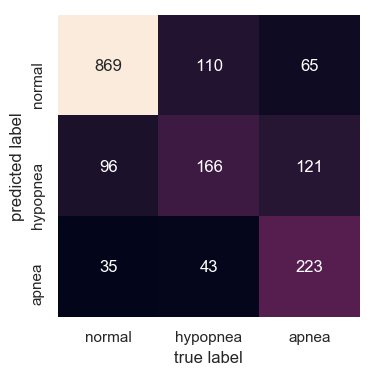

In [40]:
# confusion matrix 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix

pre = eclf.predict(test_X)
mat = confusion_matrix(test_Y, pre)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
# plt.figure()
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.rcParams['figure.dpi'] = 100 #分辨率
plt.savefig("./cm_svm")
# plt.rcParams.update({'font.size': 40})
# plt.show()